---
# processing of digital signals using Fast Fourier Transform.

This practical describes how to perform some basic sound processing functions in Python. We’ll be using the `numpy` and `matplotlib` for data analysis and `scipy` to import/export wav files.

We’ll begin by importing the necessary packages:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
%matplotlib inline

Some magic to see better quality graphs.

In [8]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)


In [15]:
import os
os.getcwd()

'C:\\Users\\Vedhanth\\Frequency Seperation\\signal_processing-master'

Next we read in a wav file. The file is already in your folder. It contains a note **A3#** played by piano and recorded with digital microphone. As some of you may know, the fundamental frequency (F0) of this note is **233.8 Hz**. At this link you can find a table with fundamental frequencies of different notes: http://pages.mtu.edu/~suits/notefreqs.html 

In [28]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)
sampFreq, sound = wavfile.read('./data/obama.wav')

You can download the file to your computer and play it with iTunes. You can hear the characteristic background noise of a low frequency. We will try to remove this noise from the signal and obtain a clearer sound. 


### Digital sound
When you hear a sound your ear's membrane oscillates because the density and pressure of the air in close proximity to the ear oscillate as well. Thus, sound recordings contain the relative signal of these oscilations. Digital audio is sound that has been recorded in, or converted into, digital form. In digital audio, the sound wave of the audio signal is encoded as numerical samples in continuous sequence. For example, in CD (or WAV) audio, samples are taken 44100 times per second each with 16 bit sample depth, i.e. there are 2^16 = 65536 possible values of the signal: from -32768 to 32767. For the example below, a sound wave, in red, represented digitally, in blue (after sampling and 4-bit quantization).

![fig1](pics/4-bit-linear-PCM.svg.png)

Typically, stereo **wav**-file contains two arrays of integers: for the right and left channel (for your right and left speaker) respectively. 

The `scipy.io.wavfile.read()` function reads wav files as `int16` (for 16-bit wavs) or `int32` (for 32-bit wavs), 24-bit wav files are not supported. We can check the type of the sound as follows:

In [29]:
sound.dtype, sampFreq

(dtype('int16'), 44100)

This means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44100 times per second.

We can convert our sound (numpy) array to floating point values ranging from -1 to 1 as follows:

In [30]:
sound = sound / 2.0**15

Now let's see the shape of the sound array. The wav file has two channels and 45568 sample points

In [31]:
sound.shape

(558720, 2)

Considering the sampling rate (sampFreq = 44110) this corresponds to a duration of around 1.03 seconds

In [32]:
length_in_s = sound.shape[0] / sampFreq
print(length_in_s)

12.66938775510204


### Plotting the sound signal on each channel

A time representation of the sound can be obtained by plotting the pressure values against the time axis. 

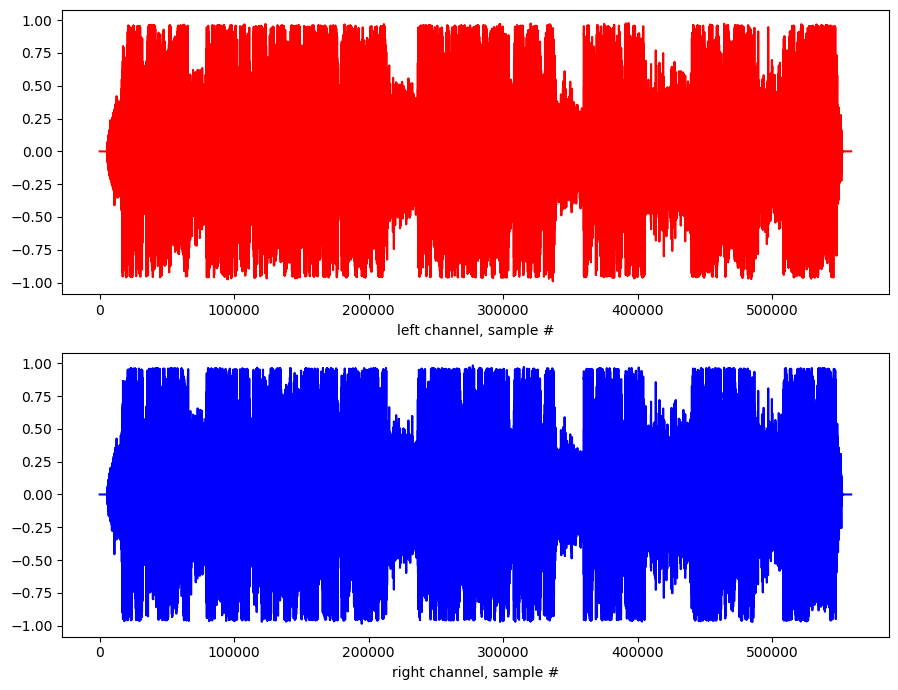

In [33]:
plt.subplot(2,1,1)
plt.plot(sound[:,0], 'r')
plt.xlabel("left channel, sample #")
plt.subplot(2,1,2)
plt.plot(sound[:,1], 'b')
plt.xlabel("right channel, sample #")
plt.tight_layout()
plt.show()

However, we need to create an array containing the time points first. To get the proper time on the x-axis we have to generate a numpy array using sampFreq:

In [34]:
time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s

Now let's look at the proper axis titles: 

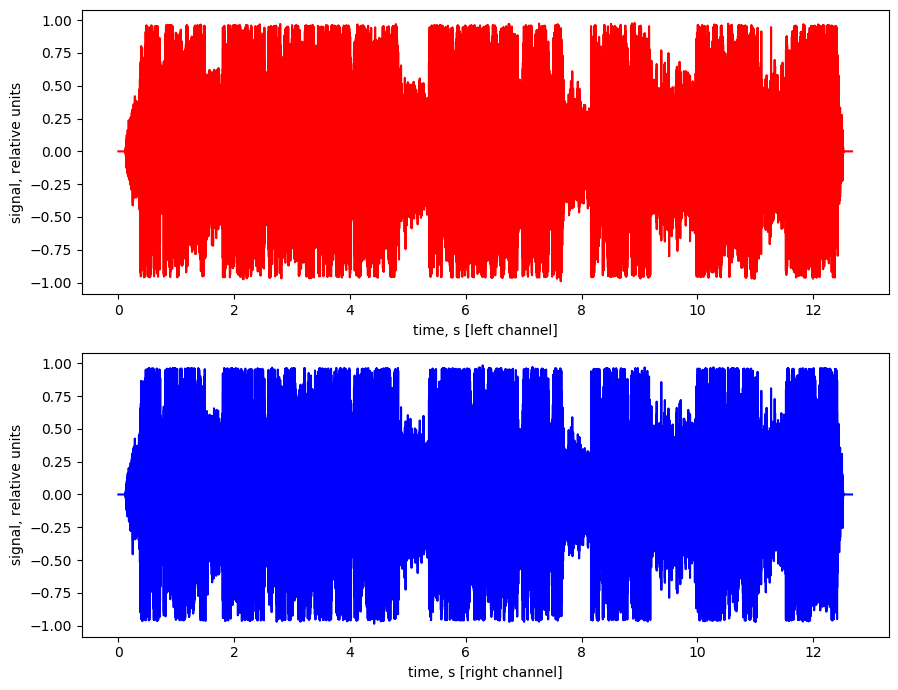

In [35]:
plt.subplot(2,1,1)
plt.plot(time, sound[:,0], 'r')
plt.xlabel("time, s [left channel]")
plt.ylabel("signal, relative units")
plt.subplot(2,1,2)
plt.plot(time, sound[:,1], 'b')
plt.xlabel("time, s [right channel]")
plt.ylabel("signal, relative units")
plt.tight_layout()
plt.show()

We will select and work with only one of the channels from now on

In [36]:
signal = sound[:,0]

We see a lot of oscillations and it's all pretty messy. We want to look at the sound with a higher resolution:

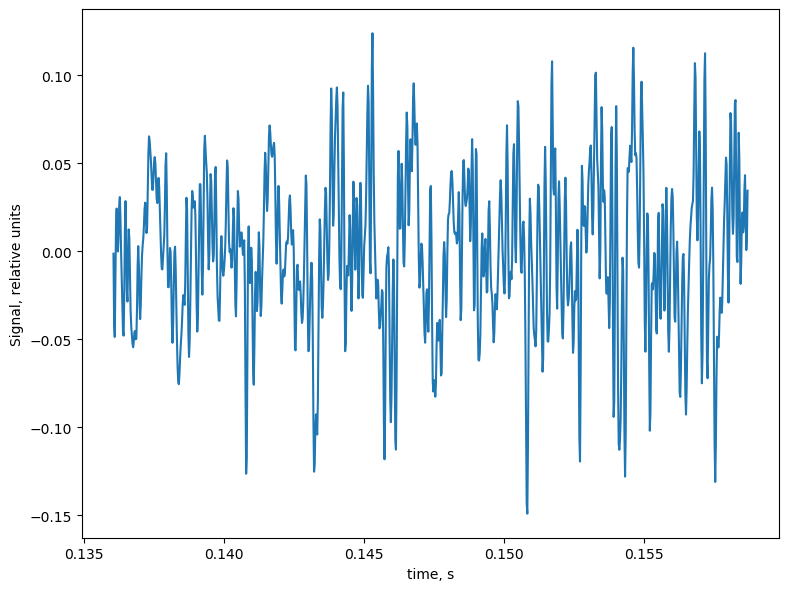

In [37]:
plt.plot(time[6000:7000], signal[6000:7000])
plt.xlabel("time, s")
plt.ylabel("Signal, relative units")
plt.show()

Yes, this is how your ear membrane oscillates on a microsecond timescale ;-)

### Plotting the frequency content with FT
Another useful graphical representation is that of the frequency content, or spectrum of the note. The standard way of doing that is with a **discrete Fourier transform** (https://en.wikipedia.org/wiki/Discrete_Fourier_transform) using the **fast Fourier transform** (https://en.wikipedia.org/wiki/Fast_Fourier_transform) or FFT algorithm. Basically, we take a sound signal and isolate the frequencies of sine waves that make up that sound.

![fig2](pics/Fourier-transform.gif)

So we are going to use the `np.fft.rfft()` function. This is meant for data that doesn’t contain complex numbers only real numbers. The function `np.fft.rfftfreq()` always goes together with `np.fft.rfft()` because it gives the way to obtain the proper frequency units:

In [38]:
fft_spectrum = np.fft.rfft(signal)
freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)

The FFT of the data is usually complex:

In [39]:
fft_spectrum

array([-1.34342804e+02+0.00000000e+00j, -1.54842192e+01+1.91973215e+01j,
       -2.55613249e+01-1.74075730e+01j, ...,
       -7.60559157e-03-4.70708550e-03j,  2.14603174e-03+1.84763440e-03j,
       -8.27026367e-03+0.00000000e+00j])

To simplify the concept without going deeply into the theorical part, let's say that when we performe the fft to get `X = fft(x)`, we usually need to use the signal magnitude in the spectral domain: `A = |X| = sqrt(real(X)^2+ imag(X)^2)`. As for the imaginary part of the transform, it can be used to compute the signal phase: `Phi = Arg(X) = arctg(imag(X)/real(X))`. Today we do not need the phase part. So, to obtain the Amplitude vs. Frequency spectrum we find the absolute value of the fourier transform:

In [40]:
fft_spectrum_abs = np.abs(fft_spectrum)

Thus, the spectrum of the sound (frequency domain) looks like:

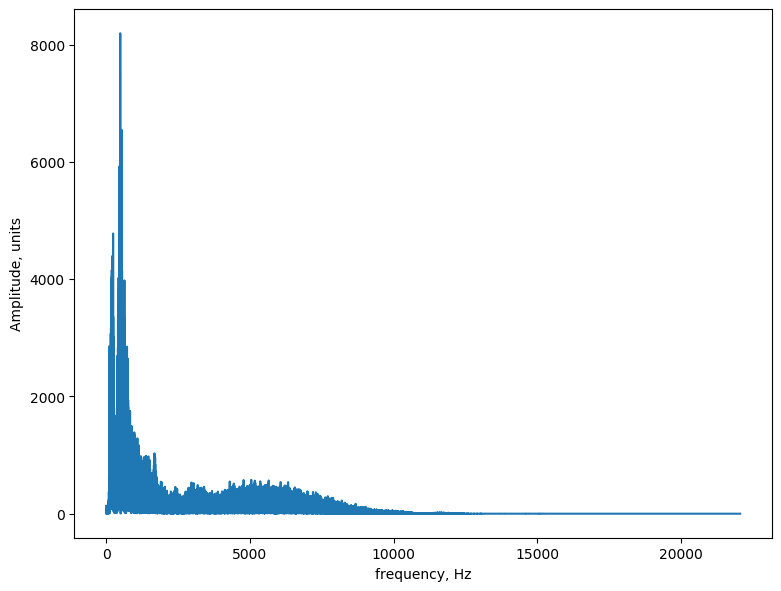

In [41]:
plt.plot(freq, fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

A human can hear a sound that is in the 20-20,000 Hz range. However, our sound doesn't contain frequencies greater than 3 kHz. It's interesting. Let's zoom in on the highest peaks:

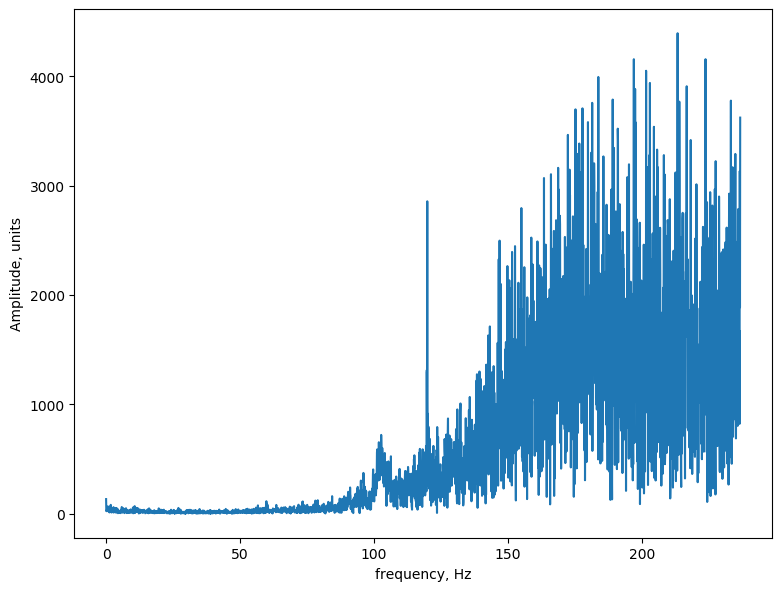

In [42]:
plt.plot(freq[:3000], fft_spectrum_abs[:3000])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

We see a lot of equally spaced peaks, and the distance between them is ~235 Hz. Let's zoom in even more:

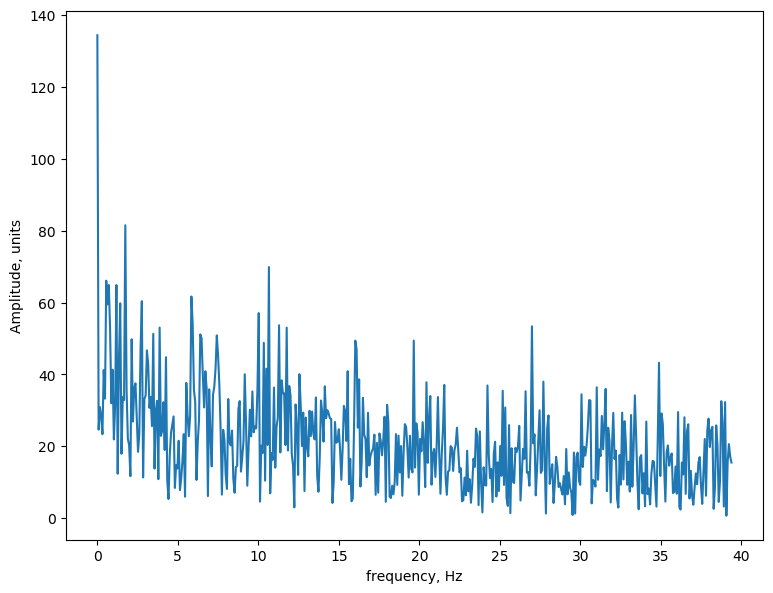

In [50]:
plt.plot(freq[:500], fft_spectrum_abs[:500])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")

plt.show()

The plot shows one big spike at and around 60 Hz (black arrow). This is the frequency standard used for AC (Alternating Current) in North America where, probably, the recording was made, and it is very noticable when you play a sound. In Europe, for example, the standard frequency is 50 Hz.

This effect is called **electric hum** (details https://en.wikipedia.org/wiki/Mains_hum). In short, because of ubiquitous AC electromagnetic fields from nearby appliances and wiring, 60 Hz electrical noise can get into audio systems. This reaches the microphone and is recorded. When recording using the built-in microphone on a laptop, a good way to prevent this is to disconnect the battery charger when recording.

The second highest peak is called a fundamental frequency (green arrow) - and it's near **233 Hz**. The other spikes are called overtone harmonics and are multiples of the fundamental frequency. We see that except 60 Hz noise, there are spikes around 233 Hz, 465 Hz, 698 Hz, 932 Hz, 1167 Hz, 1401 Hz and 1638 Hz (all are multiples of ~233 Hz). 

For music lovers: our sound is a **semitone A** of the third octave (or **A3#**) geneated by piano. Let's look at all the peaks more thoroughly:

In [55]:
import librosa
for i,f in enumerate(fft_spectrum_abs):
    if f > 350: #looking at amplitudes of the spikes higher than 350 
        print('frequency = {}{} Hz with amplitude {} '.format(librosa.hz_to_note(np.round(freq[i])),,  np.round(f)))

frequency = G2 Hz with amplitude 374.0 
frequency = G2 Hz with amplitude 359.0 
frequency = G2 Hz with amplitude 406.0 
frequency = G♯2 Hz with amplitude 364.0 
frequency = G♯2 Hz with amplitude 358.0 
frequency = G♯2 Hz with amplitude 559.0 
frequency = G♯2 Hz with amplitude 589.0 
frequency = G♯2 Hz with amplitude 510.0 
frequency = G♯2 Hz with amplitude 450.0 
frequency = G♯2 Hz with amplitude 418.0 
frequency = G♯2 Hz with amplitude 479.0 
frequency = G♯2 Hz with amplitude 654.0 
frequency = G♯2 Hz with amplitude 427.0 
frequency = G♯2 Hz with amplitude 397.0 
frequency = G♯2 Hz with amplitude 440.0 
frequency = G♯2 Hz with amplitude 607.0 
frequency = G♯2 Hz with amplitude 439.0 
frequency = G♯2 Hz with amplitude 578.0 
frequency = G♯2 Hz with amplitude 542.0 
frequency = G♯2 Hz with amplitude 434.0 
frequency = G♯2 Hz with amplitude 351.0 
frequency = G♯2 Hz with amplitude 721.0 
frequency = G♯2 Hz with amplitude 623.0 
frequency = G♯2 Hz with amplitude 414.0 
frequency = G♯2 Hz 

frequency = D♯3 Hz with amplitude 906.0 
frequency = D♯3 Hz with amplitude 1164.0 
frequency = D♯3 Hz with amplitude 737.0 
frequency = D♯3 Hz with amplitude 624.0 
frequency = D♯3 Hz with amplitude 1124.0 
frequency = D♯3 Hz with amplitude 1414.0 
frequency = D♯3 Hz with amplitude 1350.0 
frequency = D♯3 Hz with amplitude 1138.0 
frequency = D♯3 Hz with amplitude 2796.0 
frequency = D♯3 Hz with amplitude 1236.0 
frequency = D♯3 Hz with amplitude 1210.0 
frequency = D♯3 Hz with amplitude 520.0 
frequency = D♯3 Hz with amplitude 1287.0 
frequency = D♯3 Hz with amplitude 1061.0 
frequency = D♯3 Hz with amplitude 479.0 
frequency = D♯3 Hz with amplitude 1106.0 
frequency = D♯3 Hz with amplitude 1873.0 
frequency = D♯3 Hz with amplitude 890.0 
frequency = D♯3 Hz with amplitude 386.0 
frequency = D♯3 Hz with amplitude 1624.0 
frequency = D♯3 Hz with amplitude 578.0 
frequency = D♯3 Hz with amplitude 698.0 
frequency = D♯3 Hz with amplitude 2255.0 
frequency = D♯3 Hz with amplitude 716.0 
fr

frequency = F♯3 Hz with amplitude 814.0 
frequency = F♯3 Hz with amplitude 2826.0 
frequency = F♯3 Hz with amplitude 1132.0 
frequency = F♯3 Hz with amplitude 788.0 
frequency = F♯3 Hz with amplitude 1825.0 
frequency = F♯3 Hz with amplitude 751.0 
frequency = F♯3 Hz with amplitude 405.0 
frequency = F♯3 Hz with amplitude 1387.0 
frequency = F♯3 Hz with amplitude 1752.0 
frequency = F♯3 Hz with amplitude 2062.0 
frequency = F♯3 Hz with amplitude 2551.0 
frequency = F♯3 Hz with amplitude 1158.0 
frequency = F♯3 Hz with amplitude 2074.0 
frequency = F♯3 Hz with amplitude 1985.0 
frequency = F♯3 Hz with amplitude 2114.0 
frequency = F♯3 Hz with amplitude 384.0 
frequency = F♯3 Hz with amplitude 418.0 
frequency = F♯3 Hz with amplitude 2466.0 
frequency = F♯3 Hz with amplitude 1488.0 
frequency = F♯3 Hz with amplitude 790.0 
frequency = F♯3 Hz with amplitude 1695.0 
frequency = F♯3 Hz with amplitude 2965.0 
frequency = F♯3 Hz with amplitude 997.0 
frequency = F♯3 Hz with amplitude 668.0 
f

frequency = A3 Hz with amplitude 1529.0 
frequency = A3 Hz with amplitude 1803.0 
frequency = A3 Hz with amplitude 720.0 
frequency = A3 Hz with amplitude 521.0 
frequency = A3 Hz with amplitude 2061.0 
frequency = A3 Hz with amplitude 2518.0 
frequency = A3 Hz with amplitude 1342.0 
frequency = A3 Hz with amplitude 1708.0 
frequency = A3 Hz with amplitude 965.0 
frequency = A3 Hz with amplitude 1387.0 
frequency = A3 Hz with amplitude 3013.0 
frequency = A3 Hz with amplitude 1882.0 
frequency = A3 Hz with amplitude 594.0 
frequency = A3 Hz with amplitude 1617.0 
frequency = A3 Hz with amplitude 1880.0 
frequency = A3 Hz with amplitude 1173.0 
frequency = A3 Hz with amplitude 771.0 
frequency = A3 Hz with amplitude 1475.0 
frequency = A3 Hz with amplitude 372.0 
frequency = A3 Hz with amplitude 1111.0 
frequency = A3 Hz with amplitude 1515.0 
frequency = A3 Hz with amplitude 1015.0 
frequency = A3 Hz with amplitude 1276.0 
frequency = A3 Hz with amplitude 1300.0 
frequency = A3 Hz with

frequency = B3 Hz with amplitude 750.0 
frequency = B3 Hz with amplitude 1550.0 
frequency = B3 Hz with amplitude 1681.0 
frequency = B3 Hz with amplitude 1067.0 
frequency = B3 Hz with amplitude 840.0 
frequency = B3 Hz with amplitude 936.0 
frequency = B3 Hz with amplitude 1696.0 
frequency = B3 Hz with amplitude 1066.0 
frequency = B3 Hz with amplitude 1331.0 
frequency = B3 Hz with amplitude 1632.0 
frequency = B3 Hz with amplitude 569.0 
frequency = B3 Hz with amplitude 485.0 
frequency = B3 Hz with amplitude 1272.0 
frequency = B3 Hz with amplitude 2480.0 
frequency = B3 Hz with amplitude 609.0 
frequency = B3 Hz with amplitude 626.0 
frequency = B3 Hz with amplitude 1552.0 
frequency = B3 Hz with amplitude 1594.0 
frequency = B3 Hz with amplitude 837.0 
frequency = B3 Hz with amplitude 787.0 
frequency = B3 Hz with amplitude 657.0 
frequency = B3 Hz with amplitude 1728.0 
frequency = B3 Hz with amplitude 1636.0 
frequency = B3 Hz with amplitude 1237.0 
frequency = B3 Hz with amp

frequency = D4 Hz with amplitude 398.0 
frequency = D4 Hz with amplitude 591.0 
frequency = D4 Hz with amplitude 850.0 
frequency = D4 Hz with amplitude 565.0 
frequency = D4 Hz with amplitude 767.0 
frequency = D4 Hz with amplitude 1005.0 
frequency = D4 Hz with amplitude 888.0 
frequency = D4 Hz with amplitude 718.0 
frequency = D4 Hz with amplitude 628.0 
frequency = D4 Hz with amplitude 642.0 
frequency = D4 Hz with amplitude 629.0 
frequency = D4 Hz with amplitude 724.0 
frequency = D4 Hz with amplitude 808.0 
frequency = D4 Hz with amplitude 616.0 
frequency = D4 Hz with amplitude 738.0 
frequency = D4 Hz with amplitude 604.0 
frequency = D4 Hz with amplitude 373.0 
frequency = D4 Hz with amplitude 808.0 
frequency = D4 Hz with amplitude 879.0 
frequency = D4 Hz with amplitude 552.0 
frequency = D4 Hz with amplitude 593.0 
frequency = D4 Hz with amplitude 395.0 
frequency = D4 Hz with amplitude 609.0 
frequency = D4 Hz with amplitude 422.0 
frequency = D4 Hz with amplitude 690.0 

frequency = F4 Hz with amplitude 530.0 
frequency = F4 Hz with amplitude 380.0 
frequency = F4 Hz with amplitude 431.0 
frequency = F4 Hz with amplitude 496.0 
frequency = F4 Hz with amplitude 402.0 
frequency = F4 Hz with amplitude 739.0 
frequency = F4 Hz with amplitude 966.0 
frequency = F4 Hz with amplitude 424.0 
frequency = F4 Hz with amplitude 599.0 
frequency = F4 Hz with amplitude 801.0 
frequency = F4 Hz with amplitude 582.0 
frequency = F4 Hz with amplitude 384.0 
frequency = F4 Hz with amplitude 452.0 
frequency = F4 Hz with amplitude 532.0 
frequency = F4 Hz with amplitude 394.0 
frequency = F4 Hz with amplitude 446.0 
frequency = F4 Hz with amplitude 411.0 
frequency = F4 Hz with amplitude 651.0 
frequency = F4 Hz with amplitude 399.0 
frequency = F4 Hz with amplitude 463.0 
frequency = F4 Hz with amplitude 496.0 
frequency = F4 Hz with amplitude 997.0 
frequency = F4 Hz with amplitude 653.0 
frequency = F4 Hz with amplitude 505.0 
frequency = F4 Hz with amplitude 651.0 


frequency = G4 Hz with amplitude 680.0 
frequency = G4 Hz with amplitude 722.0 
frequency = G4 Hz with amplitude 1458.0 
frequency = G4 Hz with amplitude 698.0 
frequency = G4 Hz with amplitude 1875.0 
frequency = G4 Hz with amplitude 593.0 
frequency = G4 Hz with amplitude 619.0 
frequency = G4 Hz with amplitude 1274.0 
frequency = G4 Hz with amplitude 1032.0 
frequency = G4 Hz with amplitude 1427.0 
frequency = G4 Hz with amplitude 1293.0 
frequency = G4 Hz with amplitude 1725.0 
frequency = G4 Hz with amplitude 611.0 
frequency = G4 Hz with amplitude 999.0 
frequency = G4 Hz with amplitude 2059.0 
frequency = G4 Hz with amplitude 1041.0 
frequency = G4 Hz with amplitude 1947.0 
frequency = G4 Hz with amplitude 1480.0 
frequency = G4 Hz with amplitude 1391.0 
frequency = G4 Hz with amplitude 423.0 
frequency = G4 Hz with amplitude 1949.0 
frequency = G4 Hz with amplitude 1159.0 
frequency = G4 Hz with amplitude 448.0 
frequency = G4 Hz with amplitude 2235.0 
frequency = G4 Hz with am

frequency = G♯4 Hz with amplitude 600.0 
frequency = G♯4 Hz with amplitude 1444.0 
frequency = G♯4 Hz with amplitude 1984.0 
frequency = G♯4 Hz with amplitude 826.0 
frequency = G♯4 Hz with amplitude 1826.0 
frequency = G♯4 Hz with amplitude 415.0 
frequency = G♯4 Hz with amplitude 2227.0 
frequency = G♯4 Hz with amplitude 2469.0 
frequency = G♯4 Hz with amplitude 1376.0 
frequency = G♯4 Hz with amplitude 1446.0 
frequency = G♯4 Hz with amplitude 403.0 
frequency = G♯4 Hz with amplitude 961.0 
frequency = G♯4 Hz with amplitude 2810.0 
frequency = G♯4 Hz with amplitude 2402.0 
frequency = G♯4 Hz with amplitude 2106.0 
frequency = G♯4 Hz with amplitude 1900.0 
frequency = G♯4 Hz with amplitude 1149.0 
frequency = G♯4 Hz with amplitude 2185.0 
frequency = G♯4 Hz with amplitude 1130.0 
frequency = G♯4 Hz with amplitude 525.0 
frequency = G♯4 Hz with amplitude 2185.0 
frequency = G♯4 Hz with amplitude 2569.0 
frequency = G♯4 Hz with amplitude 812.0 
frequency = G♯4 Hz with amplitude 2648.0 

frequency = A♯4 Hz with amplitude 2776.0 
frequency = A♯4 Hz with amplitude 2869.0 
frequency = A♯4 Hz with amplitude 1116.0 
frequency = A♯4 Hz with amplitude 1301.0 
frequency = A♯4 Hz with amplitude 2264.0 
frequency = A♯4 Hz with amplitude 607.0 
frequency = A♯4 Hz with amplitude 1753.0 
frequency = A♯4 Hz with amplitude 2607.0 
frequency = A♯4 Hz with amplitude 2432.0 
frequency = A♯4 Hz with amplitude 2286.0 
frequency = A♯4 Hz with amplitude 2338.0 
frequency = A♯4 Hz with amplitude 1290.0 
frequency = A♯4 Hz with amplitude 895.0 
frequency = A♯4 Hz with amplitude 2635.0 
frequency = A♯4 Hz with amplitude 1276.0 
frequency = A♯4 Hz with amplitude 1789.0 
frequency = A♯4 Hz with amplitude 739.0 
frequency = A♯4 Hz with amplitude 1830.0 
frequency = A♯4 Hz with amplitude 1870.0 
frequency = A♯4 Hz with amplitude 2045.0 
frequency = A♯4 Hz with amplitude 2454.0 
frequency = A♯4 Hz with amplitude 930.0 
frequency = A♯4 Hz with amplitude 579.0 
frequency = A♯4 Hz with amplitude 2139.

frequency = B4 Hz with amplitude 3494.0 
frequency = B4 Hz with amplitude 5044.0 
frequency = B4 Hz with amplitude 3807.0 
frequency = B4 Hz with amplitude 4454.0 
frequency = B4 Hz with amplitude 3570.0 
frequency = B4 Hz with amplitude 2823.0 
frequency = B4 Hz with amplitude 1698.0 
frequency = B4 Hz with amplitude 4791.0 
frequency = B4 Hz with amplitude 2077.0 
frequency = B4 Hz with amplitude 4475.0 
frequency = B4 Hz with amplitude 1640.0 
frequency = B4 Hz with amplitude 3402.0 
frequency = B4 Hz with amplitude 2804.0 
frequency = B4 Hz with amplitude 780.0 
frequency = B4 Hz with amplitude 2645.0 
frequency = B4 Hz with amplitude 4273.0 
frequency = B4 Hz with amplitude 5268.0 
frequency = B4 Hz with amplitude 3103.0 
frequency = B4 Hz with amplitude 4073.0 
frequency = B4 Hz with amplitude 3243.0 
frequency = B4 Hz with amplitude 2307.0 
frequency = B4 Hz with amplitude 4114.0 
frequency = B4 Hz with amplitude 1378.0 
frequency = B4 Hz with amplitude 5614.0 
frequency = B4 Hz

frequency = C5 Hz with amplitude 1601.0 
frequency = C5 Hz with amplitude 3015.0 
frequency = C5 Hz with amplitude 3503.0 
frequency = C5 Hz with amplitude 3424.0 
frequency = C5 Hz with amplitude 994.0 
frequency = C5 Hz with amplitude 1562.0 
frequency = C5 Hz with amplitude 1666.0 
frequency = C5 Hz with amplitude 1604.0 
frequency = C5 Hz with amplitude 1264.0 
frequency = C5 Hz with amplitude 3234.0 
frequency = C5 Hz with amplitude 2109.0 
frequency = C5 Hz with amplitude 1263.0 
frequency = C5 Hz with amplitude 470.0 
frequency = C5 Hz with amplitude 816.0 
frequency = C5 Hz with amplitude 2659.0 
frequency = C5 Hz with amplitude 2717.0 
frequency = C5 Hz with amplitude 2756.0 
frequency = C5 Hz with amplitude 3659.0 
frequency = C5 Hz with amplitude 1241.0 
frequency = C5 Hz with amplitude 654.0 
frequency = C5 Hz with amplitude 1789.0 
frequency = C5 Hz with amplitude 2247.0 
frequency = C5 Hz with amplitude 700.0 
frequency = C5 Hz with amplitude 1633.0 
frequency = C5 Hz wit

frequency = C♯5 Hz with amplitude 2131.0 
frequency = C♯5 Hz with amplitude 2339.0 
frequency = C♯5 Hz with amplitude 1754.0 
frequency = C♯5 Hz with amplitude 2328.0 
frequency = C♯5 Hz with amplitude 1412.0 
frequency = C♯5 Hz with amplitude 531.0 
frequency = C♯5 Hz with amplitude 4091.0 
frequency = C♯5 Hz with amplitude 3527.0 
frequency = C♯5 Hz with amplitude 4148.0 
frequency = C♯5 Hz with amplitude 2253.0 
frequency = C♯5 Hz with amplitude 1300.0 
frequency = C♯5 Hz with amplitude 1130.0 
frequency = C♯5 Hz with amplitude 799.0 
frequency = C♯5 Hz with amplitude 442.0 
frequency = C♯5 Hz with amplitude 1801.0 
frequency = C♯5 Hz with amplitude 1263.0 
frequency = C♯5 Hz with amplitude 1642.0 
frequency = C♯5 Hz with amplitude 2753.0 
frequency = C♯5 Hz with amplitude 3232.0 
frequency = C♯5 Hz with amplitude 1557.0 
frequency = C♯5 Hz with amplitude 1528.0 
frequency = C♯5 Hz with amplitude 1147.0 
frequency = C♯5 Hz with amplitude 1695.0 
frequency = C♯5 Hz with amplitude 154

frequency = D5 Hz with amplitude 1058.0 
frequency = D5 Hz with amplitude 1161.0 
frequency = D5 Hz with amplitude 806.0 
frequency = D5 Hz with amplitude 1053.0 
frequency = D5 Hz with amplitude 2229.0 
frequency = D5 Hz with amplitude 1748.0 
frequency = D5 Hz with amplitude 2031.0 
frequency = D5 Hz with amplitude 2002.0 
frequency = D5 Hz with amplitude 493.0 
frequency = D5 Hz with amplitude 754.0 
frequency = D5 Hz with amplitude 1241.0 
frequency = D5 Hz with amplitude 1605.0 
frequency = D5 Hz with amplitude 1015.0 
frequency = D5 Hz with amplitude 794.0 
frequency = D5 Hz with amplitude 1460.0 
frequency = D5 Hz with amplitude 2051.0 
frequency = D5 Hz with amplitude 1744.0 
frequency = D5 Hz with amplitude 860.0 
frequency = D5 Hz with amplitude 3055.0 
frequency = D5 Hz with amplitude 1662.0 
frequency = D5 Hz with amplitude 1757.0 
frequency = D5 Hz with amplitude 584.0 
frequency = D5 Hz with amplitude 1230.0 
frequency = D5 Hz with amplitude 1047.0 
frequency = D5 Hz with

frequency = D♯5 Hz with amplitude 1261.0 
frequency = D♯5 Hz with amplitude 445.0 
frequency = D♯5 Hz with amplitude 890.0 
frequency = D♯5 Hz with amplitude 658.0 
frequency = D♯5 Hz with amplitude 820.0 
frequency = D♯5 Hz with amplitude 1285.0 
frequency = D♯5 Hz with amplitude 1110.0 
frequency = D♯5 Hz with amplitude 1965.0 
frequency = D♯5 Hz with amplitude 1683.0 
frequency = D♯5 Hz with amplitude 695.0 
frequency = D♯5 Hz with amplitude 1625.0 
frequency = D♯5 Hz with amplitude 1082.0 
frequency = D♯5 Hz with amplitude 703.0 
frequency = D♯5 Hz with amplitude 903.0 
frequency = D♯5 Hz with amplitude 705.0 
frequency = D♯5 Hz with amplitude 1496.0 
frequency = D♯5 Hz with amplitude 1104.0 
frequency = D♯5 Hz with amplitude 450.0 
frequency = D♯5 Hz with amplitude 516.0 
frequency = D♯5 Hz with amplitude 1095.0 
frequency = D♯5 Hz with amplitude 351.0 
frequency = D♯5 Hz with amplitude 748.0 
frequency = D♯5 Hz with amplitude 1308.0 
frequency = D♯5 Hz with amplitude 937.0 
frequ

frequency = F5 Hz with amplitude 775.0 
frequency = F5 Hz with amplitude 1343.0 
frequency = F5 Hz with amplitude 718.0 
frequency = F5 Hz with amplitude 473.0 
frequency = F5 Hz with amplitude 1275.0 
frequency = F5 Hz with amplitude 471.0 
frequency = F5 Hz with amplitude 708.0 
frequency = F5 Hz with amplitude 376.0 
frequency = F5 Hz with amplitude 861.0 
frequency = F5 Hz with amplitude 495.0 
frequency = F5 Hz with amplitude 987.0 
frequency = F5 Hz with amplitude 553.0 
frequency = F5 Hz with amplitude 662.0 
frequency = F5 Hz with amplitude 796.0 
frequency = F5 Hz with amplitude 402.0 
frequency = F5 Hz with amplitude 600.0 
frequency = F5 Hz with amplitude 908.0 
frequency = F5 Hz with amplitude 1092.0 
frequency = F5 Hz with amplitude 948.0 
frequency = F5 Hz with amplitude 483.0 
frequency = F5 Hz with amplitude 995.0 
frequency = F5 Hz with amplitude 874.0 
frequency = F5 Hz with amplitude 769.0 
frequency = F5 Hz with amplitude 593.0 
frequency = F5 Hz with amplitude 551.

frequency = F♯5 Hz with amplitude 1502.0 
frequency = F♯5 Hz with amplitude 1511.0 
frequency = F♯5 Hz with amplitude 799.0 
frequency = F♯5 Hz with amplitude 1060.0 
frequency = F♯5 Hz with amplitude 1569.0 
frequency = F♯5 Hz with amplitude 1049.0 
frequency = F♯5 Hz with amplitude 1615.0 
frequency = F♯5 Hz with amplitude 774.0 
frequency = F♯5 Hz with amplitude 453.0 
frequency = F♯5 Hz with amplitude 1108.0 
frequency = F♯5 Hz with amplitude 1217.0 
frequency = F♯5 Hz with amplitude 1509.0 
frequency = F♯5 Hz with amplitude 1103.0 
frequency = F♯5 Hz with amplitude 1116.0 
frequency = F♯5 Hz with amplitude 1612.0 
frequency = F♯5 Hz with amplitude 2108.0 
frequency = F♯5 Hz with amplitude 2145.0 
frequency = F♯5 Hz with amplitude 1616.0 
frequency = F♯5 Hz with amplitude 1276.0 
frequency = F♯5 Hz with amplitude 2085.0 
frequency = F♯5 Hz with amplitude 1781.0 
frequency = F♯5 Hz with amplitude 1990.0 
frequency = F♯5 Hz with amplitude 2804.0 
frequency = F♯5 Hz with amplitude 171

frequency = F♯5 Hz with amplitude 1050.0 
frequency = F♯5 Hz with amplitude 923.0 
frequency = F♯5 Hz with amplitude 1177.0 
frequency = F♯5 Hz with amplitude 1120.0 
frequency = F♯5 Hz with amplitude 793.0 
frequency = F♯5 Hz with amplitude 1055.0 
frequency = F♯5 Hz with amplitude 2070.0 
frequency = F♯5 Hz with amplitude 2346.0 
frequency = F♯5 Hz with amplitude 2288.0 
frequency = F♯5 Hz with amplitude 2461.0 
frequency = F♯5 Hz with amplitude 2371.0 
frequency = F♯5 Hz with amplitude 1625.0 
frequency = F♯5 Hz with amplitude 1453.0 
frequency = F♯5 Hz with amplitude 1517.0 
frequency = F♯5 Hz with amplitude 1809.0 
frequency = F♯5 Hz with amplitude 1445.0 
frequency = F♯5 Hz with amplitude 982.0 
frequency = F♯5 Hz with amplitude 588.0 
frequency = F♯5 Hz with amplitude 634.0 
frequency = F♯5 Hz with amplitude 736.0 
frequency = F♯5 Hz with amplitude 1166.0 
frequency = F♯5 Hz with amplitude 1224.0 
frequency = F♯5 Hz with amplitude 1020.0 
frequency = F♯5 Hz with amplitude 1197.0

frequency = G5 Hz with amplitude 386.0 
frequency = G5 Hz with amplitude 693.0 
frequency = G5 Hz with amplitude 464.0 
frequency = G5 Hz with amplitude 1005.0 
frequency = G5 Hz with amplitude 1451.0 
frequency = G5 Hz with amplitude 479.0 
frequency = G5 Hz with amplitude 1227.0 
frequency = G5 Hz with amplitude 358.0 
frequency = G5 Hz with amplitude 957.0 
frequency = G5 Hz with amplitude 899.0 
frequency = G5 Hz with amplitude 578.0 
frequency = G5 Hz with amplitude 835.0 
frequency = G5 Hz with amplitude 941.0 
frequency = G5 Hz with amplitude 771.0 
frequency = G5 Hz with amplitude 1177.0 
frequency = G5 Hz with amplitude 768.0 
frequency = G5 Hz with amplitude 503.0 
frequency = G5 Hz with amplitude 902.0 
frequency = G5 Hz with amplitude 624.0 
frequency = G5 Hz with amplitude 700.0 
frequency = G5 Hz with amplitude 1017.0 
frequency = G5 Hz with amplitude 686.0 
frequency = G5 Hz with amplitude 803.0 
frequency = G5 Hz with amplitude 910.0 
frequency = G5 Hz with amplitude 85

frequency = G♯5 Hz with amplitude 763.0 
frequency = G♯5 Hz with amplitude 867.0 
frequency = G♯5 Hz with amplitude 391.0 
frequency = G♯5 Hz with amplitude 593.0 
frequency = G♯5 Hz with amplitude 609.0 
frequency = G♯5 Hz with amplitude 1060.0 
frequency = G♯5 Hz with amplitude 951.0 
frequency = G♯5 Hz with amplitude 511.0 
frequency = G♯5 Hz with amplitude 631.0 
frequency = G♯5 Hz with amplitude 399.0 
frequency = G♯5 Hz with amplitude 669.0 
frequency = G♯5 Hz with amplitude 442.0 
frequency = G♯5 Hz with amplitude 597.0 
frequency = G♯5 Hz with amplitude 871.0 
frequency = G♯5 Hz with amplitude 479.0 
frequency = G♯5 Hz with amplitude 539.0 
frequency = G♯5 Hz with amplitude 1224.0 
frequency = G♯5 Hz with amplitude 797.0 
frequency = G♯5 Hz with amplitude 395.0 
frequency = G♯5 Hz with amplitude 822.0 
frequency = G♯5 Hz with amplitude 557.0 
frequency = G♯5 Hz with amplitude 466.0 
frequency = G♯5 Hz with amplitude 429.0 
frequency = G♯5 Hz with amplitude 595.0 
frequency = G♯

frequency = A5 Hz with amplitude 702.0 
frequency = A5 Hz with amplitude 693.0 
frequency = A5 Hz with amplitude 717.0 
frequency = A5 Hz with amplitude 658.0 
frequency = A5 Hz with amplitude 777.0 
frequency = A5 Hz with amplitude 828.0 
frequency = A5 Hz with amplitude 835.0 
frequency = A5 Hz with amplitude 490.0 
frequency = A5 Hz with amplitude 441.0 
frequency = A5 Hz with amplitude 446.0 
frequency = A5 Hz with amplitude 952.0 
frequency = A5 Hz with amplitude 534.0 
frequency = A5 Hz with amplitude 628.0 
frequency = A5 Hz with amplitude 755.0 
frequency = A5 Hz with amplitude 724.0 
frequency = A5 Hz with amplitude 461.0 
frequency = A5 Hz with amplitude 386.0 
frequency = A5 Hz with amplitude 463.0 
frequency = A5 Hz with amplitude 535.0 
frequency = A5 Hz with amplitude 459.0 
frequency = A5 Hz with amplitude 493.0 
frequency = A5 Hz with amplitude 717.0 
frequency = A5 Hz with amplitude 684.0 
frequency = A5 Hz with amplitude 440.0 
frequency = A5 Hz with amplitude 408.0 


frequency = A♯5 Hz with amplitude 440.0 
frequency = A♯5 Hz with amplitude 510.0 
frequency = A♯5 Hz with amplitude 366.0 
frequency = A♯5 Hz with amplitude 523.0 
frequency = A♯5 Hz with amplitude 465.0 
frequency = A♯5 Hz with amplitude 446.0 
frequency = A♯5 Hz with amplitude 423.0 
frequency = A♯5 Hz with amplitude 921.0 
frequency = A♯5 Hz with amplitude 1035.0 
frequency = A♯5 Hz with amplitude 508.0 
frequency = A♯5 Hz with amplitude 424.0 
frequency = A♯5 Hz with amplitude 374.0 
frequency = A♯5 Hz with amplitude 596.0 
frequency = A♯5 Hz with amplitude 663.0 
frequency = A♯5 Hz with amplitude 463.0 
frequency = A♯5 Hz with amplitude 506.0 
frequency = A♯5 Hz with amplitude 731.0 
frequency = A♯5 Hz with amplitude 781.0 
frequency = A♯5 Hz with amplitude 867.0 
frequency = A♯5 Hz with amplitude 680.0 
frequency = A♯5 Hz with amplitude 864.0 
frequency = A♯5 Hz with amplitude 694.0 
frequency = A♯5 Hz with amplitude 683.0 
frequency = A♯5 Hz with amplitude 581.0 
frequency = A♯5

frequency = A6 Hz with amplitude 361.0 
frequency = A6 Hz with amplitude 377.0 
frequency = A6 Hz with amplitude 440.0 
frequency = A6 Hz with amplitude 538.0 
frequency = A6 Hz with amplitude 402.0 
frequency = A6 Hz with amplitude 505.0 
frequency = A6 Hz with amplitude 418.0 
frequency = A6 Hz with amplitude 488.0 
frequency = A6 Hz with amplitude 405.0 
frequency = A6 Hz with amplitude 430.0 
frequency = A6 Hz with amplitude 425.0 
frequency = A6 Hz with amplitude 431.0 
frequency = A6 Hz with amplitude 382.0 
frequency = A6 Hz with amplitude 582.0 
frequency = A6 Hz with amplitude 514.0 
frequency = A6 Hz with amplitude 563.0 
frequency = A6 Hz with amplitude 374.0 
frequency = A6 Hz with amplitude 384.0 
frequency = A6 Hz with amplitude 359.0 
frequency = A6 Hz with amplitude 425.0 
frequency = A6 Hz with amplitude 353.0 
frequency = A6 Hz with amplitude 520.0 
frequency = A6 Hz with amplitude 377.0 
frequency = A6 Hz with amplitude 353.0 
frequency = A6 Hz with amplitude 421.0 


frequency = C♯8 Hz with amplitude 418.0 
frequency = C♯8 Hz with amplitude 391.0 
frequency = C♯8 Hz with amplitude 386.0 
frequency = C♯8 Hz with amplitude 388.0 
frequency = C♯8 Hz with amplitude 369.0 
frequency = C♯8 Hz with amplitude 379.0 
frequency = C♯8 Hz with amplitude 352.0 
frequency = C♯8 Hz with amplitude 355.0 
frequency = C♯8 Hz with amplitude 366.0 
frequency = C♯8 Hz with amplitude 391.0 
frequency = C♯8 Hz with amplitude 414.0 
frequency = C♯8 Hz with amplitude 381.0 
frequency = C♯8 Hz with amplitude 396.0 
frequency = C♯8 Hz with amplitude 403.0 
frequency = C♯8 Hz with amplitude 387.0 
frequency = C♯8 Hz with amplitude 351.0 
frequency = C♯8 Hz with amplitude 367.0 
frequency = C♯8 Hz with amplitude 372.0 
frequency = C♯8 Hz with amplitude 374.0 
frequency = C♯8 Hz with amplitude 358.0 
frequency = D8 Hz with amplitude 351.0 
frequency = D8 Hz with amplitude 361.0 
frequency = D8 Hz with amplitude 422.0 
frequency = D8 Hz with amplitude 361.0 
frequency = D8 Hz wi

frequency = F8 Hz with amplitude 421.0 
frequency = F8 Hz with amplitude 360.0 
frequency = F8 Hz with amplitude 351.0 
frequency = F8 Hz with amplitude 442.0 
frequency = F8 Hz with amplitude 360.0 
frequency = F8 Hz with amplitude 406.0 
frequency = F8 Hz with amplitude 354.0 
frequency = F8 Hz with amplitude 428.0 
frequency = F8 Hz with amplitude 390.0 
frequency = F8 Hz with amplitude 372.0 
frequency = F8 Hz with amplitude 412.0 
frequency = F8 Hz with amplitude 383.0 
frequency = F8 Hz with amplitude 358.0 
frequency = F8 Hz with amplitude 358.0 
frequency = F8 Hz with amplitude 358.0 
frequency = F8 Hz with amplitude 354.0 
frequency = F8 Hz with amplitude 420.0 
frequency = F8 Hz with amplitude 373.0 
frequency = F8 Hz with amplitude 411.0 
frequency = F8 Hz with amplitude 454.0 
frequency = F8 Hz with amplitude 403.0 
frequency = F8 Hz with amplitude 408.0 
frequency = F♯8 Hz with amplitude 382.0 
frequency = F♯8 Hz with amplitude 412.0 
frequency = F♯8 Hz with amplitude 411.

The way to filter the electric hum sound is to set the amplitudes of the FFT values around 60 Hz to 0, see (1) in the code below. In addition to filtering this peak, we're also going to remove the frequencies below the human hearing range and above the normal human voice range (2).

In [46]:
for i,f in enumerate(freq):
    if f < 62 and f > 58:# (1)
        fft_spectrum[i] = 0.0
    if f < 21 or f > 20000:# (2)
        fft_spectrum[i] = 0.0

Let's look again on the spectrum. 

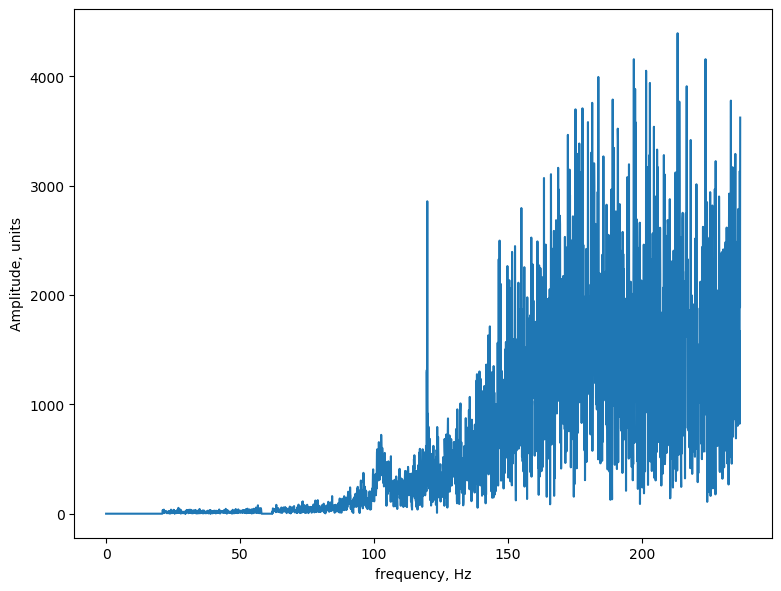

In [47]:
plt.plot(freq[:3000], np.abs(fft_spectrum[:3000]))
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

We see no spikes in the 60 Hz region. Then we recreate the original signal via an inverse FFT:

In [48]:
noiseless_signal = np.fft.irfft(fft_spectrum)

Let's save the noiseless sound in a file, download it from the jupyterhub folder and play it in iTunes (can you hear a difference?):

In [49]:
wavfile.write("data/noiseless_a3s.wav", sampFreq, noiseless_signal)

## Problem 1. 

In your folder there is a wav-file called `data/unknown.wav`. This is the sound of a note played on a piano and recorded without AC noise. You have to find the fundamental frequency and determine the note, using the table http://pages.mtu.edu/~suits/notefreqs.html, materials from today's practical and any possible Internet resources.

## Problem 2. 

In the `unknown.wav` find the fundamental frequency and remove all the overtones form the Fourier spectrum. Restore the original sound, save it with the filename `data/no_overtones.wav` and play the sound in iTunes to hear if you like it. Think about why overtones, physically, is the important part of string instruments. Hint: https://en.wikipedia.org/wiki/Overtone#String_instruments